<a href="https://colab.research.google.com/github/priyahasan/ML/blob/master/DBSCAN_6913.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# importing the libraries

In [ ]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt


In [ ]:
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

In [ ]:
!pip install astroquery

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 910.2/910.2 kB 23.9 MB/s eta 0:00:00


In [ ]:
# import astroquery
import astropy.units as u
import astropy.coordinates as coord
from astroquery.gaia import Gaia
from astroquery.vizier import Vizier



Important: Gaia archive will be intermittently unavailable due to scheduled maintenance (deployment of a new version) on Friday 22nd from 9.00h to 11.00h


# Loading the data

In [ ]:
def get_GAIA_data(name, radius = 0.5, table = 'gaiadr3.gaia_source',
                  search = True, preprocess = True, *args, **kwargs):
    '''
    Collects the data from GAIA Archive for the given object by conesearch within
    a given radius from a given table. Then preprocessed the data to remove noisy
    data and to apply other cutoffs (i.e., |pm| < 20 mas/yr )
    '''

    if search:
        # conesearch using the object name and radius
        coordinate = coord.SkyCoord.from_name(name)
        print(f'Object Name: {name}')
        print('Co-ordinate', coordinate)

        radius = u.Quantity(radius, u.deg)
        Gaia.ROW_LIMIT = -1
        table = table
        j = Gaia.cone_search_async(coordinate, radius, table_name = table)
        r = j.get_results()

        all_stars = r.to_pandas()
        print(f'Total Raw Stars: {len(all_stars)}')


    all_stars["X"]=1000/(all_stars["parallax"])*np.cos(all_stars["dec"])*np.cos(all_stars["ra"])
    all_stars["Y"]=1000/(all_stars["parallax"])*np.cos(all_stars["dec"])*np.sin(all_stars["ra"])
    all_stars["Z"]=1000/(all_stars["parallax"])*np.sin(all_stars["dec"])

    #print(all_stars.head())

    ## plotting the skyplot
    sns.set(rc={'figure.figsize':(8.7,6.27)})
    skyplot = sns.scatterplot(x='ra', y='dec', data = all_stars)
    skyplot.invert_xaxis()
    plt.title('Skyplot of GAIA data')
    plt.show()

    if preprocess:
        ## magnitude error
        ## del magnitude = - 2.5 log(del Flux / Flux)
        all_stars['g_mag_error'] = 2.5/np.log(10) / all_stars.phot_g_mean_flux_over_error

        mask = (all_stars.parallax_over_error >= 3) & (all_stars.pmra_error < 1) \
                & (all_stars.pmdec_error < 1) & (all_stars.parallax > 0)& (all_stars.ruwe < 1.4)

        all_stars = all_stars.loc[mask, :]
        print(f'Number of stars after applying noise filter: {len(all_stars)}')

        # calculating the distance from the parallax
        all_stars['distance_pc'] = 1/(all_stars.parallax*0.001)

        # positive parallax
        all_stars = all_stars[all_stars['parallax'] >= 0]

        # dropping rows with null values in required columns
        all_stars = all_stars[all_stars.loc[:, 'pmra'].notnull()]
        all_stars = all_stars[all_stars.loc[:, 'parallax'].notnull()]
        all_stars = all_stars[all_stars.loc[:, 'bp_rp'].notnull()]

        # defining proper motion (pm) range
        all_stars = all_stars[(abs(all_stars['pmra']) < 20) & (abs(all_stars['pmdec']) < 20)]

        # taking stars within 30' = 0.5 deg radius
        # all_stars = all_stars[all_stars['dist'] < (30/60)]
        print(f'Number of stars after applying other filters: {len(all_stars)}')

    return all_stars

In [ ]:
def get_normalized_feature(all_stars, feature_columns = ['pmra', 'pmdec', 'parallax']):
    # selecting the features
    features = all_stars.loc[:, feature_columns]
    features = features.dropna()

    # normalizing the features
    scaled_features = pd.DataFrame({})
    for column in features.columns:
        scaled_features[column] = (features[column] - np.median(features[column]))/np.std(features[column])

    return scaled_features

Getting MNN and MSS values

In [ ]:
def get_members(all_stars, scaled_features, eps, min_sample):
    db = DBSCAN(eps= eps,min_samples= min_sample).fit(scaled_features)

    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_

    all_stars['labels'] = labels
    all_stars['is_core'] = core_samples_mask

    member, non_member = all_stars[all_stars.labels == 0],\
                         all_stars[all_stars.labels == -1]
    return member, non_member


In [ ]:
def mean_nearest_neighbor(member_data, feature_columns = ['pmra', 'pmdec', 'parallax']):
    '''
    returns the average of the nearest neighbor distance for all the member stars
    '''

    # normalizing the features
    scaled_member_features = get_normalized_feature(member_data, feature_columns)

    nn_model = NearestNeighbors(n_neighbors=2) # model to find 1st nearest neighbor

    nn_members = nn_model.fit(scaled_member_features)        # training the model using normalized dataset

    nn_distances, nn_indices = nn_members.kneighbors(scaled_member_features) #[(distance, index of the 30th nearest neighbor)]

    mnn = np.mean(nn_distances[:, 1])

    return mnn


In [ ]:
def get_MSS_metric(member, non_member, epsilon = 1e-7,
                   feature_columns = ['pmra', 'pmdec', 'parallax']):
    '''
    Returns the Modified Silhouttee Score for given member and non_member data
    '''
    if len(member) < 2 or len(non_member) < 2:
        return 0

    metric = np.zeros(len(feature_columns))
    for i in range(len(feature_columns)):
        feature_i = feature_columns[i]
        # (field_SD - member SD)/max(field_SD, member SD, epsilon) for each features
        metric[i] = (np.std(non_member[feature_i]) - np.std(member[feature_i])) \
                / max(np.std(member[feature_i]), np.std(non_member[feature_i]), epsilon)

    mss_metric = metric.mean()
    return mss_metric

In [ ]:
def compare_DBSCAN_parameters(all_stars, scaled_features,
                              eps, min_samples):

    # running DBSCAN with all possible parameters
    mnn_values = np.full((len(eps), len(min_samples)), -1, dtype = 'float32')
    n_members = np.full((len(eps), len(min_samples)), -1, dtype = 'float32')
    mss_metrics = np.full((len(eps), len(min_samples)), -1, dtype = 'float32')

    for i in range(len(eps)):
        ep = eps[i]
        for j in range(len(min_samples)):
            min_sample = min_samples[j]

            member, non_member = get_members(all_stars, scaled_features, ep, min_sample)
            try:
                mnn_values[i,j] = mean_nearest_neighbor(member)
            # if there is any error comes up, we will continue the program by keeping -1 as the MNN value
            except:
                pass
            mss_metrics[i,j] = get_MSS_metric(member, non_member)
            n_members[i,j] = len(member)

    # Creating a DataFrame with paramters and metrics
    model_parameters = pd.DataFrame({'eps': np.repeat(eps, len(min_samples)),
                        'min_sample': np.tile(min_samples, len(eps)),
                        'mnn': mnn_values.flatten(),
                        'mss': mss_metrics.flatten(),
                        'n_member' : n_members.flatten()})

    model_parameters = model_parameters[model_parameters.mnn > 0] # removing the rows where MNN is negative


    # Visualize the change in metric values
    plt.figure(figsize = (20,6))
    plt.legend.set_title(new_title)
    plt.subplot(131)
    sns.lineplot(x='eps', y='mnn', hue = 'min_sample', data = model_parameters,
                 legend = 'full')

    plt.subplot(132)
    sns.lineplot(x='eps', y='mss', hue = 'min_sample', data = model_parameters,
                 legend = 'full')

    plt.subplot(133)
    sns.lineplot(x='eps', y='n_member', hue = 'min_sample', data = model_parameters,
                 legend = 'full')
    plt.show()

    return model_parameters

Additional Function for Comparing with Cantat

In [ ]:
def get_cantat_data(data = 'member', clusters = None):
    if data == 'cluster':
        if clusters == None:
            cantat_data = Vizier(catalog = 'J/A+A/633/A99/table1',
                             row_limit = -1).query_constraints()
        else:
            cantat_data = Vizier(catalog = 'J/A+A/633/A99/table1',
                                row_limit = -1).query_constraints(Cluster = clusters)
        cantat_data = cantat_data[0].to_pandas()
        return cantat_data

    if data == 'member':
        if clusters == None:
            cantat_data = Vizier(catalog = 'J/A+A/633/A99/members',
                             row_limit = -1).query_constraints()
        else:
            cantat_data = Vizier(catalog = 'J/A+A/633/A99/members',
                                row_limit = -1).query_constraints(Cluster = clusters)
        cantat_data = cantat_data[0].to_pandas()

        # renaming the cantat table to match it with gaia_data
        cantat_data = cantat_data.rename(columns={'Source':'source_id',
                                                'Proba':'PMemb',
                                                'RA_ICRS': 'ra',
                                                'DE_ICRS': 'dec',
                                                'pmRA': 'pmra',
                                                'pmDE': 'pmdec',
                                                'Gmag': 'phot_g_mean_mag',
                                                'BP-RP': 'bp_rp',
                                                'Plx': 'parallax'})


        return cantat_data


In [ ]:
def get_rf_member(cluster_name):
    rf_data = pd.read_csv('https://raw.githubusercontent.com/mahmud-nobe/Cluster-Membership/master/all_possible_members.csv', index_col=0)
    rf_member = rf_data[rf_data.cluster == cluster_name]

    if len(rf_member) == 0:
        print(f'The cluster, {cluster_name}, is not present in RF data.\n')
    return rf_member

In [ ]:
def compare_with_cantat(cluster_name, dbscan_member, cantat_member, alpha = 1):

    concatenated = pd.concat([dbscan_member.assign(dataset='DBSCAN'),
                            #rf_member.assign(dataset = 'RF'),
                            cantat_member.assign(dataset='Cantat')])
    # concatenated.reset_index(drop=True)
    print(f'Cluster: {cluster_name}')
    print(concatenated.dataset.value_counts())
    print(f'Cantat (PMemb > 0.5): {sum(cantat_member.PMemb > 0.5)}')
    print('\n')

    # Distribution of parameters
    fig, axes = plt.subplots(1, 3, figsize=(20,6))
    fig.suptitle(f"Distribution of the Cantat and predicted Members of {cluster_name.replace('_', ' ')}")


    sns.histplot(data = concatenated.reset_index(), x = 'parallax', element='step',
                        hue='dataset', ax=axes[0], palette = 'Dark2', alpha = alpha)
    axes[0].set_title('Parallax Distribution')


    sns.histplot(data = concatenated.reset_index(), x = 'pmra', element='step',
                 hue='dataset', ax=axes[1], palette = 'Dark2', alpha = alpha)
    axes[1].set_title('pmra Distribution')

    sns.histplot(data = concatenated.reset_index(), x = 'pmdec', element='step',
                 hue='dataset', ax=axes[2], palette = 'Dark2', alpha = alpha)
    axes[2].set_title('pmdec Distribution')


    plt.show()


    fig, axes = plt.subplots(1, 3, figsize=(22,6))
    fig.suptitle(f"Predicted Members and Cantat Members of {cluster_name.replace('_', ' ')}")

    skyplot = sns.scatterplot(x='ra', y='dec', data=concatenated,
                    hue='dataset', ax=axes[0], palette = 'Dark2', markers=["d", 'P',],
                    style='dataset')
    axes[0].set_title('Sky plot')

    # proper motion plot
    sns.scatterplot(x='pmra', y='pmdec', data=concatenated,
                    hue='dataset', ax=axes[1], palette = 'Dark2', markers=["d", 'P',],
                    style='dataset')
    axes[1].set_title('Proper motion plot')

    #cmd = sns.scatterplot(x='BP-RP', y='Gmag', data=concatenated,
    #cmd = sns.scatterplot(x='bp_rp', y='phot_g_mean_mag', data=concatenated,
    #cmd = sns.scatterplot(x='bp_rp', y='phot_g_mean_mag', data=concatenated,
                    #hue='dataset', ax=axes[2], palette = 'Dark2', markers=["d", "P",],
                    #style='dataset')
    cmd = sns.scatterplot(x='bp_rp', y='phot_g_mean_mag', data=concatenated,
                    hue='dataset', ax=axes[2], palette = 'Dark2', markers=["d", "P",],s=20,
                    style='dataset')

    cmd.set_xlim([-1, 5])
    cmd.invert_yaxis()
    axes[2].set_title('CMD')

    plt.show()


In [ ]:
#len(member), len(rf_member)

RUNNING THE CODE

In [ ]:
cluster_name = 'NGC_3293'
#all_stars = pd.read_csv('https://drive.google.com/file/d/1zzBa8sCwVzcSqu8PWAy4gPvxy_vFA-4i/view?usp=drive_link/ngc6451_allstars.csv')#
all_stars = pd.read_csv('ngc3293_allstars.csv')
#all_stars = get_GAIA_data(cluster_name, radius = 0.6)

FileNotFoundError: [Errno 2] No such file or directory: 'ngc3293_allstars.csv'

In [ ]:
all_stars

,RA_ICRS,DE_ICRS,Source,e_RA_ICRS,e_DE_ICRS,Plx,e_Plx,RPlx,PM,pmRA,...,TYC2,URAT1,AllWISE,APASS9,GSC23,RAVE5,2MASS,RAVE6,RAJ2000,DEJ2000
0,159.189413,-58.716415,5350657582933399296,0.0291,0.0257,0.9345,0.0331,28.2297,6.945,-6.237,...,NaN,NaN,NaN,NaN,S4AY020407,NaN,10364547-5842591,NaN,159.189466,-58.716428
1,159.108738,-58.720295,5350657681698599168,0.2839,0.2545,1.6475,0.3286,5.0135,7.796,7.066,...,NaN,NaN,NaN,NaN,NaN,NaN,10362610-5843128,NaN,159.108677,-58.720281
2,159.102657,-58.722791,5350657686012731392,0.0200,0.0167,0.6081,0.0216,28.1072,8.732,-7.873,...,NaN,NaN,NaN,40907544.0,S4AZ029959,NaN,10362463-5843220,NaN,159.102724,-58.722808
3,159.121069,-58.721980,5350657716055128448,0.0816,0.0671,0.3306,0.0844,3.9175,5.431,-5.377,...,NaN,NaN,NaN,NaN,S4AZ029969,NaN,10362905-5843192,NaN,159.121115,-58.721984
4,159.128672,-58.714110,5350657716055480448,0.0777,0.0716,0.4751,0.0882,5.3888,7.856,-6.863,...,NaN,NaN,NaN,NaN,S4AZ058014,NaN,10363087-5842507,NaN,159.128731,-58.714126
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28850,159.311427,-57.768262,5351578179089074048,0.3431,0.3149,1.4681,0.3734,3.9320,10.619,-9.790,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,159.311508,-57.768280
28851,159.286526,-57.768597,5351578183384029824,0.1171,0.1183,0.5452,0.1444,3.7765,5.371,-5.045,...,NaN,NaN,NaN,NaN,S4C4040404,NaN,NaN,NaN,159.286568,-57.768605
28852,159.301633,-57.775896,5351578183399273856,0.0453,0.0442,0.6575,0.0558,11.7794,12.952,-4.108,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,159.301668,-57.775950
28853,159.293141,-57.763014,5351578183399284480,0.0354,0.0333,0.3788,0.0427,8.8675,4.189,-3.985,...,NaN,NaN,J103710.39-574546.9,NaN,S4C4011291,NaN,10371037-5745468,NaN,159.293175,-57.763009


In [ ]:
all_stars = all_stars.rename(columns={'Source':'source_id',
                                                'Proba':'PMemb',
                                                'RA_ICRS': 'ra',
                                                'DE_ICRS': 'dec',
                                                'pmRA': 'pmra',
                                                'pmDE': 'pmdec',
                                                'Gmag': 'phot_g_mean_mag',
                                                'BP-RP': 'bp_rp',
                                                'Plx': 'parallax'})

In [ ]:
all_stars["bp_rp"]


0        1.217331
1             NaN
2        1.559234
3        1.527405
4        2.243079
           ...   
52732    3.074275
52733    2.673744
52734         NaN
52735    1.577768
52736    2.785519
Name: bp_rp, Length: 52737, dtype: float64

In [ ]:
all_stars["phot_g_mean_mag"]

0        15.932020
1        16.755888
2        16.555046
3        18.989302
4        14.045452
           ...    
52732    15.312949
52733    17.437023
52734    17.616364
52735    16.922009
52736    17.801370
Name: phot_g_mean_mag, Length: 52737, dtype: float64

In [ ]:
#all_stars["RA_ICRS"] = all_stars["ra"]
#all_stars["DE_ICRS"] = all_stars["dec"]
#all_stars["Plx"] = all_stars["parallax"]
#all_stars["pmRA"] = all_stars["pmra"]
#all_stars["pmDE"] = all_stars["pmdec"]

Total Raw Stars: 28855


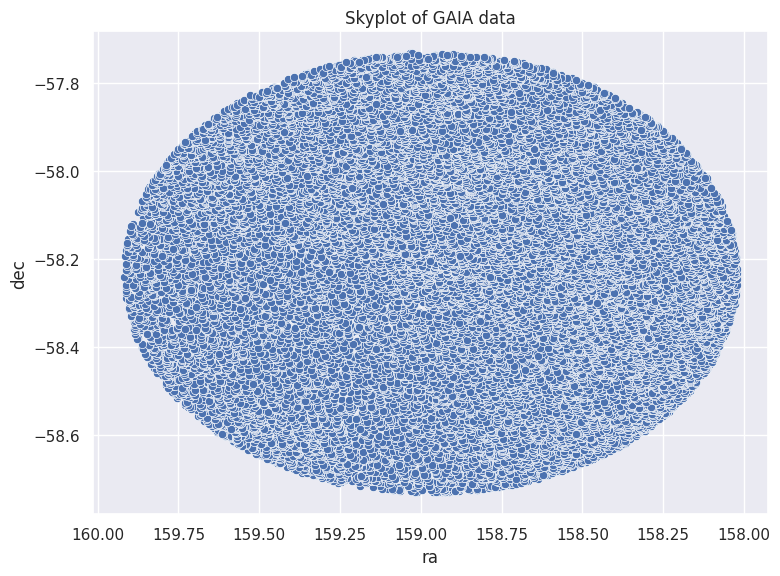

In [ ]:
print(f'Total Raw Stars: {len(all_stars)}')
        #adding pmra*,xyz
#all_stars["pmra*"]=all_stars["pmra"]
#*np.cos(all_stars["dec"])
all_stars["X"]=1000/(all_stars["parallax"])*np.cos(all_stars["dec"])*np.cos(all_stars["ra"])
all_stars["Y"]=1000/(all_stars["parallax"])*np.cos(all_stars["dec"])*np.sin(all_stars["ra"])
all_stars["Z"]=1000/(all_stars["parallax"])*np.sin(all_stars["dec"])

    #print(all_stars.head())

    ## plotting the skyplot
sns.set(rc={'figure.figsize':(8.7,6.27)})
skyplot = sns.scatterplot(x='ra', y='dec', data = all_stars)
skyplot.invert_xaxis()
plt.title('Skyplot of GAIA data')
plt.show()


In [ ]:
#mask = (all_stars.parallax_over_error >= 3) & (all_stars.pmra_error < 1) \
                #& (all_stars.pmdec_error < 1) & (all_stars.ruwe < 1.4)

#all_stars = all_stars.loc[mask, :]
    #print(f'Number of stars after applying noise filter: {len(all_stars)}')

        # calculating the distance from the parallax
all_stars['distance_pc'] = 1/(all_stars.parallax*0.001)

        # positive parallax
all_stars = all_stars[all_stars['parallax'] >= 0]

        # dropping rows with null values in required columns
all_stars = all_stars[all_stars.loc[:, 'pmra'].notnull()]
all_stars = all_stars[all_stars.loc[:, 'parallax'].notnull()]
all_stars = all_stars[all_stars.loc[:, 'bp_rp'].notnull()]

        # defining proper motion (pm) range
all_stars = all_stars[(abs(all_stars['pmra']) < 20) & (abs(all_stars['pmdec']) < 20)]

        # taking stars within 30' = 0.5 deg radius
        # all_stars = all_stars[all_stars['dist'] < (30/60)]

print(f'Number of stars after applying other filters: {len(all_stars)}')

Number of stars after applying other filters: 27552


In [ ]:
all_stars.iloc[:,9].mean(axis='index')

-6.944949804006969

In [ ]:
scaled_features = get_normalized_feature(all_stars)
#scaled_features.head()
np.mean(scaled_features)

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3502: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


pmra       -0.036014
pmdec      -0.042568
parallax    0.293225
dtype: float64

In [ ]:
all_stars.iloc[:,9].apply(np.mean)

0       -6.237
1        7.066
2       -7.873
3       -5.377
4       -6.863
         ...  
28850   -9.790
28851   -5.045
28852   -4.108
28853   -3.985
28854   -8.142
Name: pmra, Length: 27552, dtype: float64

In [ ]:
eps = np.linspace(0.02,0.1,13) # you can modify the range
min_samples = np.linspace(5,45,9, dtype =int) # you can modify the range
model_parameters = compare_DBSCAN_parameters(all_stars, scaled_features, eps, min_samples)
model_parameters.head()

NameError: name 'all_stars' is not defined

SELECTING THE HYPERPARAMETERS

Using the above three plots, select the suitable value for eps and min_sample.

Note that, we want to have low value for MNN, high value for MSS and a reasonable number of members.

In [ ]:
best_eps =   0.05 # your code here
best_min_sample = 50 # your code here

member, non_member = get_members(all_stars, scaled_features, best_eps, best_min_sample)


In [ ]:
best_MSS = get_MSS_metric(member, non_member)
best_MNN = mean_nearest_neighbor(member)
best_n_member = len(member)
print(f'Mean Nearest Neighbor distance: {best_MNN:0.2f}, \n\
        Modified Silhouette Score: {best_MSS:0.2f}, \n\
        Number of Member: {best_n_member}')

Mean Nearest Neighbor distance: 0.20, 
        Modified Silhouette Score: 0.94, 
        Number of Member: 1027


COMPARE WITH CANTAT AND RF

In [ ]:
cantat_member = get_cantat_data(clusters = cluster_name)

In [ ]:
#rf_member = get_rf_member(cluster_name)
cluster_name

Cluster: NGC_3293
DBSCAN    1027
Cantat     657
Name: dataset, dtype: int64
Cantat (PMemb > 0.5): 370




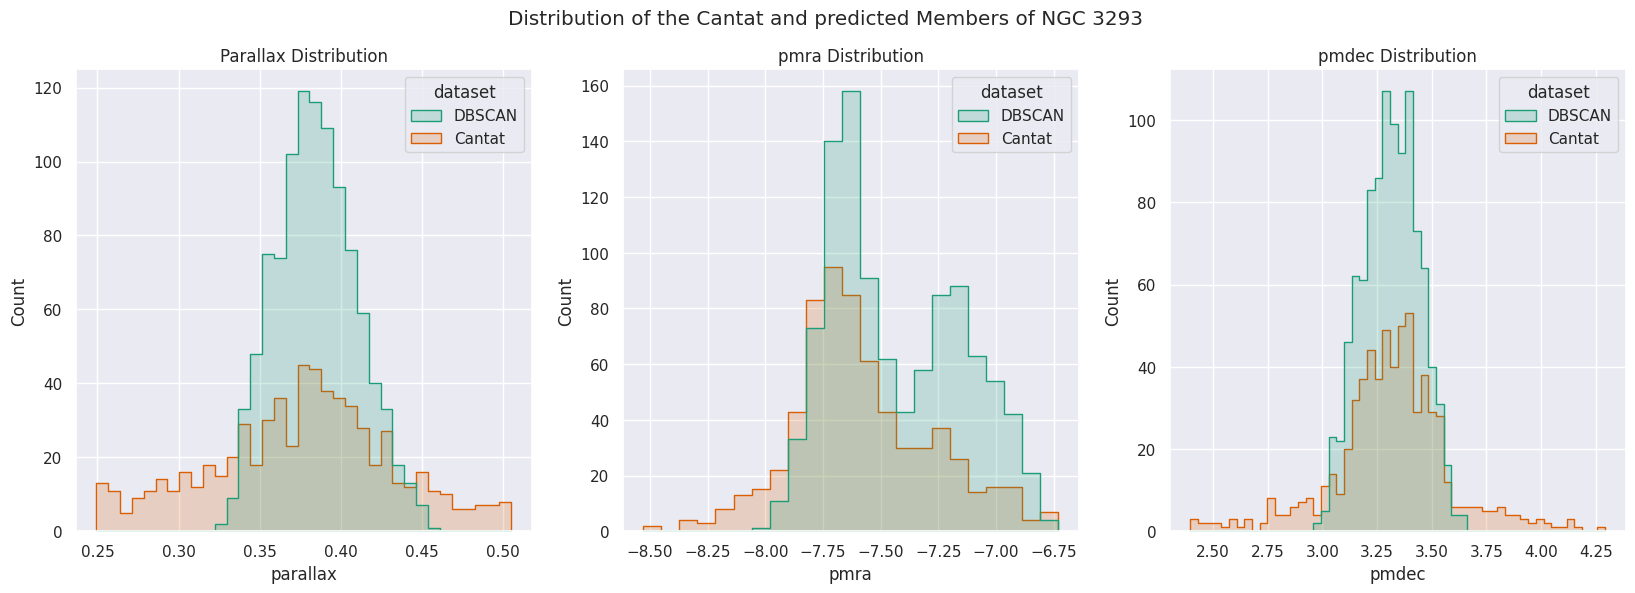

/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:1007: FutureWarning: reindexing with a non-unique Index is deprecated and will raise in a future version.
  comp_data.insert(0, var, comp_col)


ValueError: cannot reindex on an axis with duplicate labels

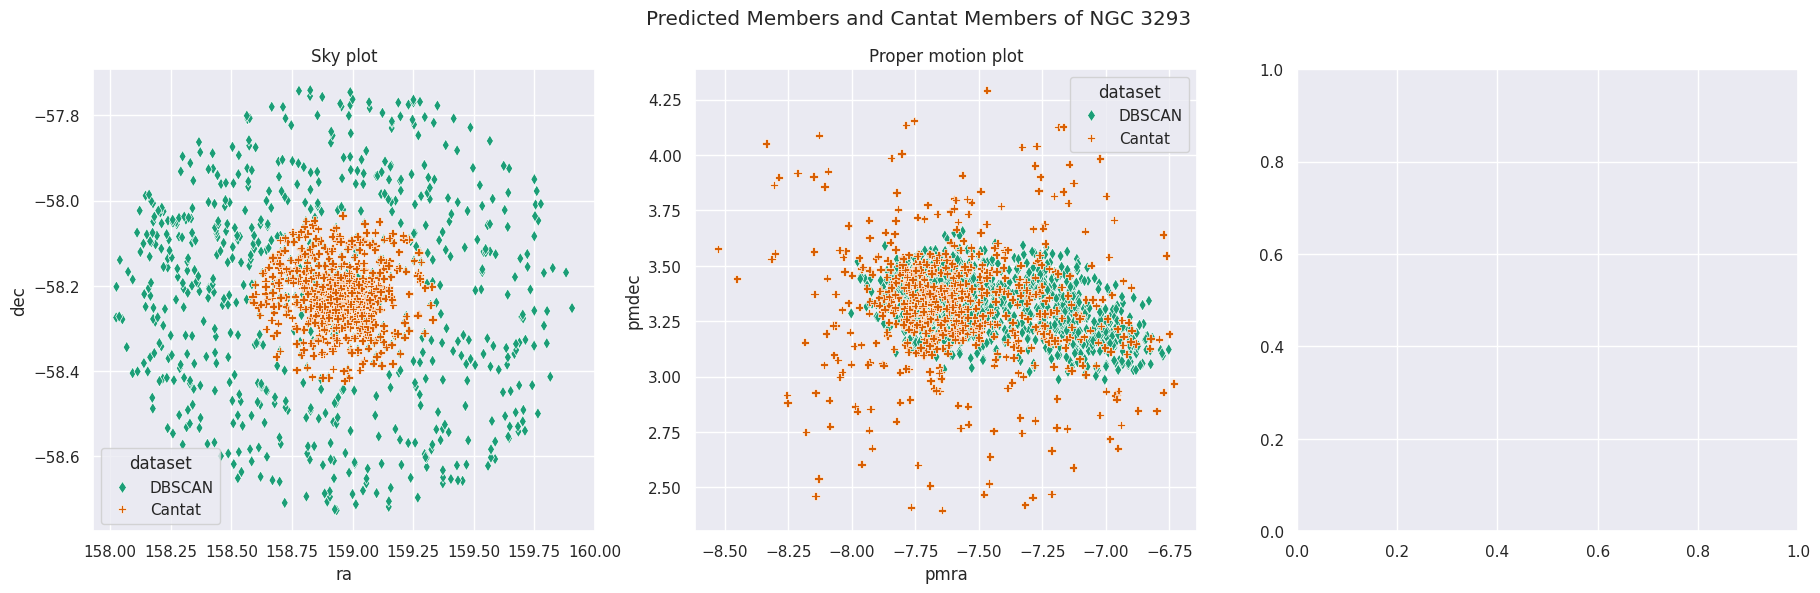

In [ ]:
compare_with_cantat(cluster_name, member, cantat_member, alpha = 0.2)

SAVING THE MEMBERS AS CSV

In [ ]:
# for downloading file
from google.colab import files
cantat_member.to_csv(f'{cluster_name}_cantat_member.csv') # saved it in a csv

In [ ]:
files.download(f'{cluster_name}_cantat_member.csv') # download in local computer

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# for downloading file
from google.colab import files
member.to_csv(f'{cluster_name}_dbscan_member.csv') # saved it in a csv

NameError: name 'member' is not defined

In [ ]:
files.download(f'{cluster_name}_dbscan_member.csv') # download in local computer

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
member

,ra,dec,source_id,e_RA_ICRS,e_DE_ICRS,parallax,e_Plx,RPlx,PM,pmra,...,2MASS,RAVE6,RAJ2000,DEJ2000,X,Y,Z,distance_pc,labels,is_core
468,274.066870,-22.609484,4090480742056065536,0.0842,0.0741,0.4425,0.0891,4.9644,1.456,1.450,...,NaN,NaN,274.066863,-22.609484,1349.493787,1252.928384,1310.010024,2259.887006,0,True
551,274.112004,-22.574653,4090480913740913792,0.0162,0.0140,0.4623,0.0178,25.9997,1.378,1.378,...,18162688-2234287,NaN,274.111997,-22.574653,1266.148500,1286.685652,1191.762999,2163.097556,0,False
605,274.061048,-22.584371,4090481051208445952,0.0894,0.0788,0.4397,0.0949,4.6323,1.245,1.227,...,NaN,NaN,274.061042,-22.584370,1389.365534,1274.965794,1271.403036,2274.277917,0,False
922,273.999076,-22.568048,4090481742744429824,0.0432,0.0365,0.3166,0.0466,6.7951,1.321,1.317,...,NaN,NaN,273.999070,-22.568049,2057.664790,1665.709331,1722.767365,3158.559697,0,False
1404,273.715833,-22.545791,4090490813718416000,0.0239,0.0195,0.4770,0.0238,20.0065,1.293,1.291,...,18145180-2232448,NaN,273.715827,-22.545791,1643.362118,689.524183,1104.065894,2096.436059,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48809,274.059447,-21.856272,4090822449541427712,0.0229,0.0193,0.4103,0.0262,15.6591,1.668,1.668,...,NaN,NaN,274.059439,-21.856271,1782.036271,1630.055939,-327.732006,2437.241043,0,False
49969,274.210924,-21.723681,4090825305697306624,0.0397,0.0341,0.4810,0.0392,12.2698,1.339,1.337,...,NaN,NaN,274.210917,-21.723681,1258.335962,1561.068154,-549.460161,2079.002079,0,False
50414,274.087090,-21.815024,4090834715968226816,0.0898,0.0768,0.4469,0.1081,4.1323,1.303,1.298,...,NaN,NaN,274.087084,-21.815024,1583.825998,1531.272781,-392.069469,2237.637055,0,True
51124,274.101077,-21.744742,4090836708875952384,0.0677,0.0628,0.3984,0.0848,4.6989,1.363,1.326,...,NaN,NaN,274.101071,-21.744744,1726.210309,1716.289511,-612.249861,2510.040161,0,False


In [ ]:
member.iloc[:,9].mean(axis='index')

1.3279147727272729